In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
df = pd.read_csv(r"C:\Users\Lilian\Downloads\online_retail_II.csv.zip")

# First look
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())

(1067371, 8)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  


In [4]:
# Check for missing values
print(df.isnull().sum())

# Clean the data
df_clean = df.copy()

# Remove rows with missing CustomerID (can't analyze customer behavior without it)
df_clean = df_clean.dropna(subset=['Customer ID'])

# Remove rows with missing Description
df_clean = df_clean.dropna(subset=['Description'])

# Remove cancelled orders (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]

# Remove negative quantities and prices (returns/errors)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]

# Remove outliers (prices above 99th percentile - likely data errors)
price_99th = df_clean['Price'].quantile(0.99)
df_clean = df_clean[df_clean['Price'] <= price_99th]

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

print(f"\nOriginal shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")

# Check the cleaned data
print(df_clean.describe())

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Original shape: (1067371, 8)
Cleaned shape: (798381, 9)
Rows removed: 268990
            Quantity                    InvoiceDate          Price  \
count  798381.000000                         798381  798381.000000   
mean       13.390574  2011-01-02 07:47:14.106648320       2.775520   
min         1.000000            2009-12-01 07:45:00       0.001000   
25%         2.000000            2010-07-07 10:37:00       1.250000   
50%         5.000000            2010-12-03 14:54:00       1.950000   
75%        12.000000            2011-07-28 13:02:00       3.750000   
max     80995.000000            2011-12-09 12:50:00      14.950000   
std       144.272808                            NaN       2.562281   

         Customer ID     TotalPrice  
count  798381.000000  798381.000000  
mean    15339.021188      

Total Revenue: $17,143,451.10
Total Transactions: 36,538
Unique Customers: 5,843
Unique Products: 4,569
Average Order Value: $469.20


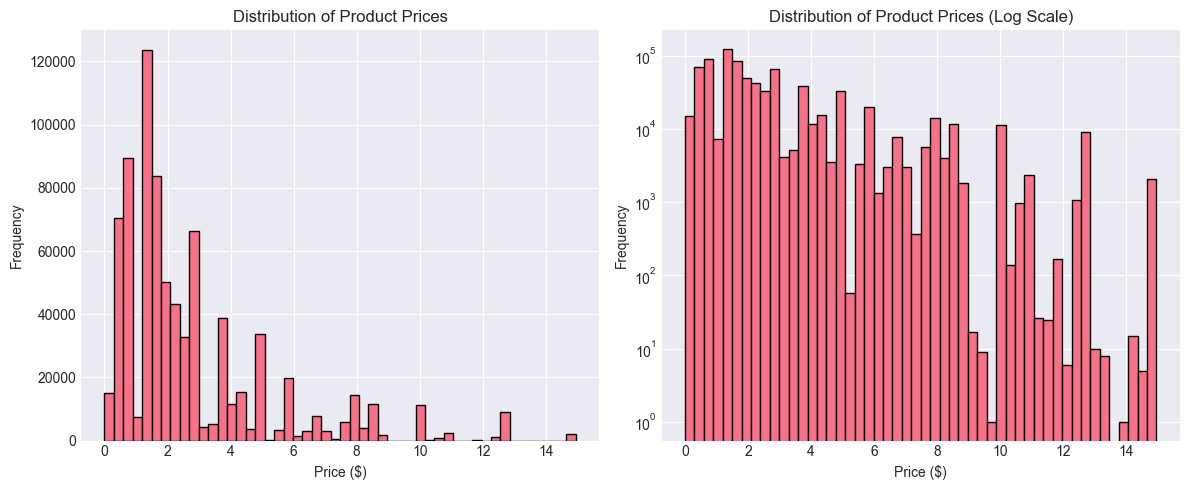

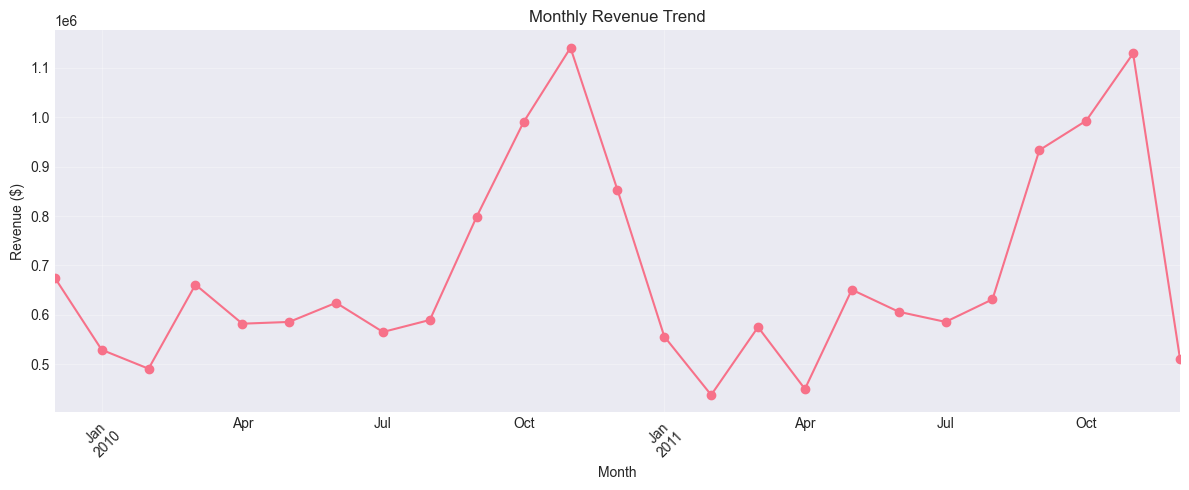

In [5]:
# 1. Revenue Overview
total_revenue = df_clean['TotalPrice'].sum()
total_transactions = df_clean['Invoice'].nunique()
unique_customers = df_clean['Customer ID'].nunique()
unique_products = df_clean['StockCode'].nunique()

print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Transactions: {total_transactions:,}")
print(f"Unique Customers: {unique_customers:,}")
print(f"Unique Products: {unique_products:,}")
print(f"Average Order Value: ${total_revenue/total_transactions:,.2f}")

# 2. Price Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_clean['Price'], bins=50, edgecolor='black')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')

plt.subplot(1, 2, 2)
plt.hist(df_clean['Price'], bins=50, edgecolor='black')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices (Log Scale)')
plt.yscale('log')

plt.tight_layout()
plt.savefig('price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Revenue by Month
df_clean['YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M')
monthly_revenue = df_clean.groupby('YearMonth')['TotalPrice'].sum()

plt.figure(figsize=(12, 5))
monthly_revenue.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('monthly_revenue.png', dpi=300, bbox_inches='tight')
plt.show()


=== PRICE ELASTICITY ANALYSIS ===
StockCode                         Description  Elasticity  R_Squared  AvgPrice  TotalRevenue
    22423            REGENCY CAKESTAND 3 TIER    4.200826   0.393448 12.424503     286111.90
   85123A  WHITE HANGING HEART T-LIGHT HOLDER   -2.778098   0.118549  2.870366     252227.81
   85099B         JUMBO BAG RED WHITE SPOTTY    -8.072753   0.600655  1.959759     170616.68
    84879       ASSORTED COLOUR BIRD ORNAMENT   -7.372899   0.086718  1.676403     127074.17
    47566                       PARTY BUNTING    0.140473   0.000361  4.771579     103880.23
    22086     PAPER CHAIN KIT 50'S CHRISTMAS    -2.337595   0.207855  2.919336      79594.33
    79321                       CHILLI LIGHTS   -3.004500   0.349582  5.128969      72860.14
    22386     JUMBO BAG PINK WITH WHITE SPOTS   -4.088790   0.231580  1.969579      68439.19
    21137            BLACK RECORD COVER FRAME   -9.251963   0.970508  3.629065      67209.44
    48138                 DOOR MAT 

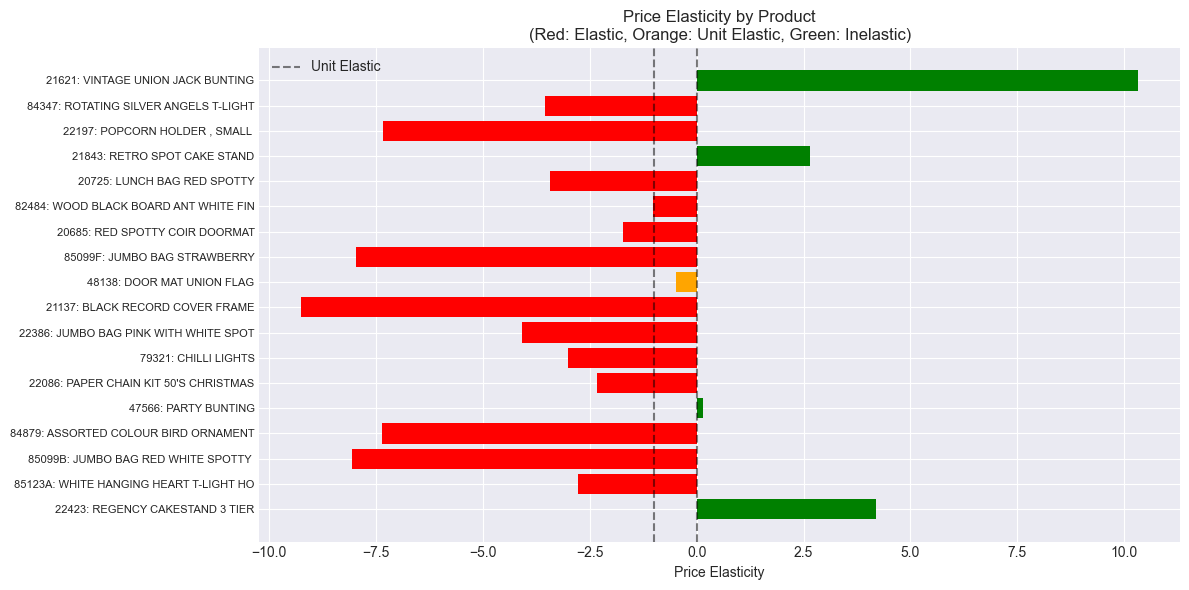


Elastic products (|E| > 1): 13
Inelastic products (|E| < 1): 5


In [6]:
# Select top 20 products by revenue for detailed analysis
top_products = (df_clean.groupby('StockCode')['TotalPrice']
                .sum()
                .sort_values(ascending=False)
                .head(20)
                .index)

df_top = df_clean[df_clean['StockCode'].isin(top_products)].copy()

# Calculate elasticity for each product
elasticity_results = []

for product in top_products:
    product_data = df_clean[df_clean['StockCode'] == product].copy()
    
    # Group by price point and calculate average quantity demanded
    price_demand = (product_data.groupby('Price')
                    .agg({'Quantity': 'sum', 'Invoice': 'count'})
                    .reset_index())
    
    # Need at least 3 different price points to calculate elasticity
    if len(price_demand) < 3:
        continue
    
    # Calculate price elasticity using log-log regression
    # ln(Q) = a + b*ln(P), where b is the elasticity
    price_demand['ln_price'] = np.log(price_demand['Price'])
    price_demand['ln_quantity'] = np.log(price_demand['Quantity'])
    
    # Remove any infinite values
    price_demand = price_demand.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(price_demand) < 3:
        continue
    
    # Fit linear regression
    X = price_demand[['ln_price']]
    y = price_demand['ln_quantity']
    
    model = LinearRegression()
    model.fit(X, y)
    
    elasticity = model.coef_[0]
    r_squared = model.score(X, y)
    
    # Get product description and average price
    description = product_data['Description'].iloc[0]
    avg_price = product_data['Price'].mean()
    total_revenue = product_data['TotalPrice'].sum()
    
    elasticity_results.append({
        'StockCode': product,
        'Description': description,
        'Elasticity': elasticity,
        'R_Squared': r_squared,
        'AvgPrice': avg_price,
        'TotalRevenue': total_revenue
    })

# Create DataFrame
elasticity_df = pd.DataFrame(elasticity_results)
elasticity_df = elasticity_df.sort_values('TotalRevenue', ascending=False)

print("\n=== PRICE ELASTICITY ANALYSIS ===")
print(elasticity_df.to_string(index=False))

# Visualize elasticity
plt.figure(figsize=(12, 6))
colors = ['red' if x < -1 else 'orange' if x < 0 else 'green' 
          for x in elasticity_df['Elasticity']]

plt.barh(range(len(elasticity_df)), elasticity_df['Elasticity'], color=colors)
plt.yticks(range(len(elasticity_df)), 
           [f"{row['StockCode']}: {row['Description'][:30]}" 
            for _, row in elasticity_df.iterrows()], 
           fontsize=8)
plt.xlabel('Price Elasticity')
plt.title('Price Elasticity by Product\n(Red: Elastic, Orange: Unit Elastic, Green: Inelastic)')
plt.axvline(x=-1, color='black', linestyle='--', alpha=0.5, label='Unit Elastic')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('price_elasticity.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
elastic_products = len(elasticity_df[elasticity_df['Elasticity'] < -1])
inelastic_products = len(elasticity_df[elasticity_df['Elasticity'] > -1])

print(f"\nElastic products (|E| > 1): {elastic_products}")
print(f"Inelastic products (|E| < 1): {inelastic_products}")


=== CUSTOMER SEGMENTATION ===
Segment
Budget      2340
Standard    1774
Premium     1729
Name: count, dtype: int64


         Customer ID Monetary              Frequency Recency
               count     mean          sum      mean    mean
Segment                                                     
Budget          2340   378.15    884872.31      1.46  363.56
Premium         1729  8052.26  13922361.39     15.14   38.00
Standard        1774  1316.92   2336217.40      3.91  142.49


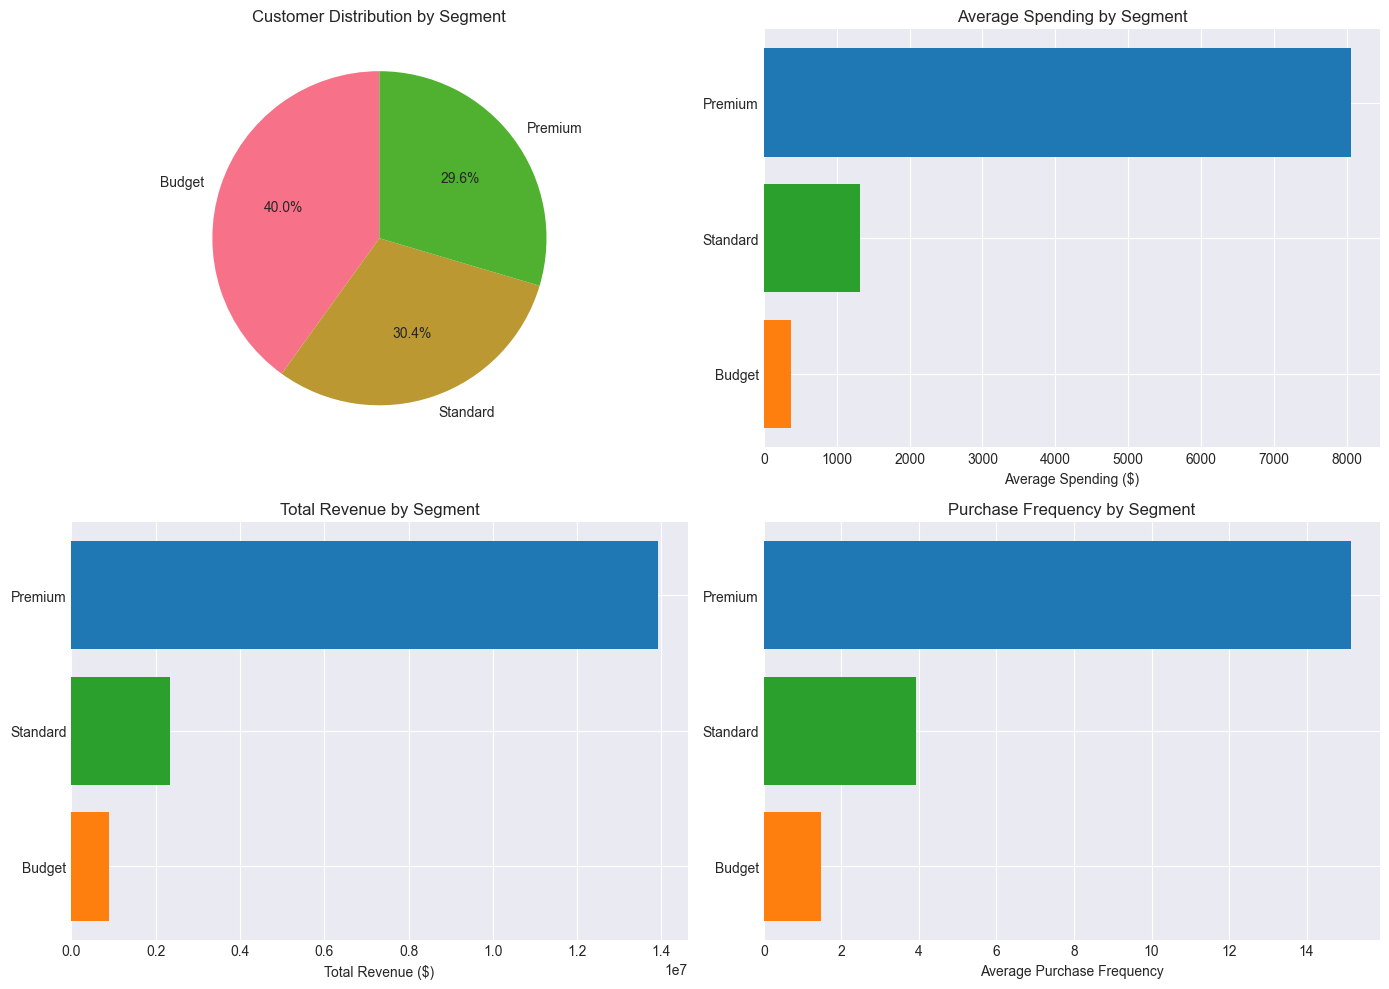

In [7]:
# Calculate RFM metrics
# Use the last date in dataset as reference
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Create RFM scores (1-4 scale)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Convert to numeric
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Calculate RFM Score
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Create segments
def segment_customers(row):
    if row['RFM_Score'] >= 10:
        return 'Premium'
    elif row['RFM_Score'] >= 7:
        return 'Standard'
    else:
        return 'Budget'

rfm['Segment'] = rfm.apply(segment_customers, axis=1)

print("\n=== CUSTOMER SEGMENTATION ===")
print(rfm['Segment'].value_counts())
print("\n")

# Segment statistics
segment_stats = rfm.groupby('Segment').agg({
    'Customer ID': 'count',
    'Monetary': ['mean', 'sum'],
    'Frequency': 'mean',
    'Recency': 'mean'
}).round(2)

print(segment_stats)

# Visualize segments
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Segment distribution
segment_counts = rfm['Segment'].value_counts()
axes[0, 0].pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Customer Distribution by Segment')

# Average spending by segment
segment_monetary = rfm.groupby('Segment')['Monetary'].mean().sort_values()
axes[0, 1].barh(segment_monetary.index, segment_monetary.values, color=['#ff7f0e', '#2ca02c', '#1f77b4'])
axes[0, 1].set_xlabel('Average Spending ($)')
axes[0, 1].set_title('Average Spending by Segment')

# Total revenue by segment
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values()
axes[1, 0].barh(segment_revenue.index, segment_revenue.values, color=['#ff7f0e', '#2ca02c', '#1f77b4'])
axes[1, 0].set_xlabel('Total Revenue ($)')
axes[1, 0].set_title('Total Revenue by Segment')

# Purchase frequency by segment
segment_frequency = rfm.groupby('Segment')['Frequency'].mean().sort_values()
axes[1, 1].barh(segment_frequency.index, segment_frequency.values, color=['#ff7f0e', '#2ca02c', '#1f77b4'])
axes[1, 1].set_xlabel('Average Purchase Frequency')
axes[1, 1].set_title('Purchase Frequency by Segment')

plt.tight_layout()
plt.savefig('customer_segments.png', dpi=300, bbox_inches='tight')
plt.show()


=== PRICING STRATEGY RECOMMENDATIONS ===

CURRENT STATE:
Total Revenue: $17,143,451.10
Total Customers: 5,843
Average Customer Value: $2,934.02

CUSTOMER SEGMENTS:
Premium (1729 customers): Avg spend $8,052.26
Standard (1774 customers): Avg spend $1,316.92
Budget (2340 customers): Avg spend $378.15

RECOMMENDED PRICING TIERS:

TIER 1 - VALUE:
  Target: Price-sensitive customers
  Price Point: 15% below current average
  Expected Customers: 2,808
  Avg Customer Value: $321.43
  Projected Revenue: $902,569.76

TIER 2 - STANDARD:
  Target: Mainstream customers
  Price Point: Current average
  Expected Customers: 1,774
  Avg Customer Value: $1,316.92
  Projected Revenue: $2,336,217.40

TIER 3 - PREMIUM:
  Target: High-value customers
  Price Point: 30% premium for exclusive benefits
  Expected Customers: 1,556
  Avg Customer Value: $10,467.94
  Projected Revenue: $16,288,116.03

PROJECTED IMPACT:
Current Revenue: $17,143,451.10
Projected Revenue: $19,526,903.19
Revenue Increase: $2,383,45

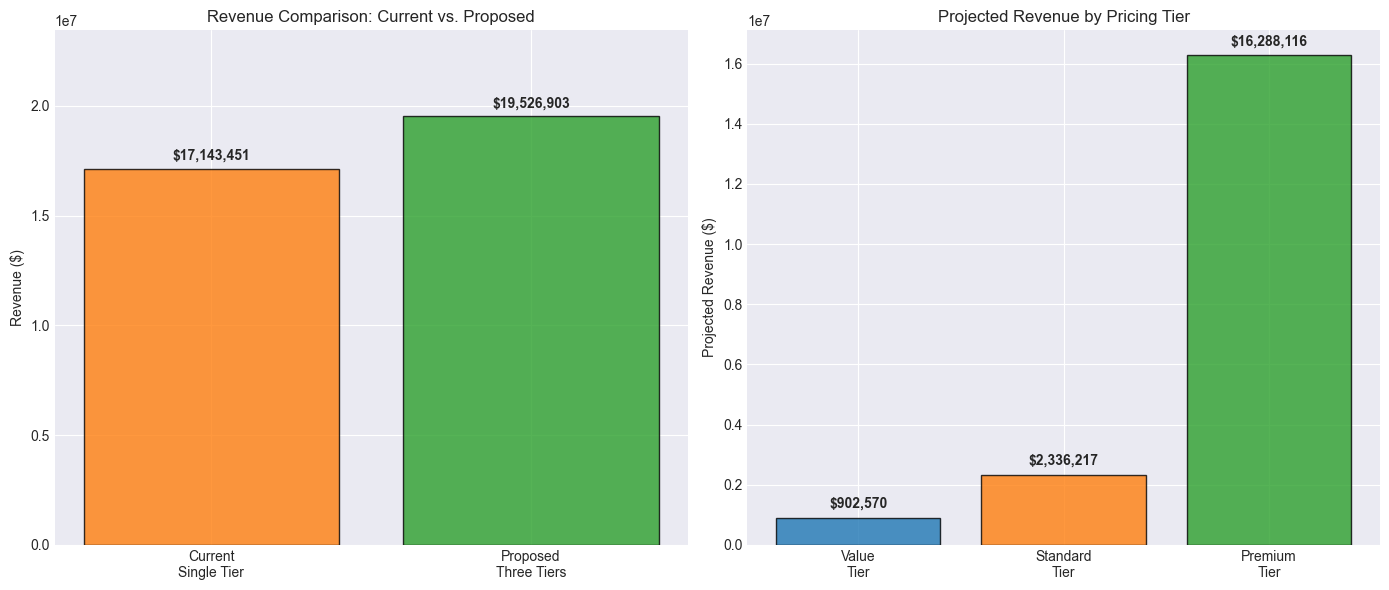

In [8]:
# Calculate optimal pricing strategy
print("\n=== PRICING STRATEGY RECOMMENDATIONS ===\n")

# Current state
current_revenue = df_clean['TotalPrice'].sum()
current_customers = df_clean['Customer ID'].nunique()
avg_customer_value = current_revenue / current_customers

print(f"CURRENT STATE:")
print(f"Total Revenue: ${current_revenue:,.2f}")
print(f"Total Customers: {current_customers:,}")
print(f"Average Customer Value: ${avg_customer_value:,.2f}\n")

# Segment analysis
premium_customers = len(rfm[rfm['Segment'] == 'Premium'])
standard_customers = len(rfm[rfm['Segment'] == 'Standard'])
budget_customers = len(rfm[rfm['Segment'] == 'Budget'])

premium_avg_spend = rfm[rfm['Segment'] == 'Premium']['Monetary'].mean()
standard_avg_spend = rfm[rfm['Segment'] == 'Standard']['Monetary'].mean()
budget_avg_spend = rfm[rfm['Segment'] == 'Budget']['Monetary'].mean()

print(f"CUSTOMER SEGMENTS:")
print(f"Premium ({premium_customers} customers): Avg spend ${premium_avg_spend:,.2f}")
print(f"Standard ({standard_customers} customers): Avg spend ${standard_avg_spend:,.2f}")
print(f"Budget ({budget_customers} customers): Avg spend ${budget_avg_spend:,.2f}\n")

# Pricing tier recommendations
print("RECOMMENDED PRICING TIERS:\n")

# Tier 1: Budget (capture price-sensitive customers)
tier1_price_reduction = 0.15  # 15% lower than current average
tier1_customers = int(budget_customers * 1.2)  # Assume 20% growth from lower prices
tier1_avg_spend = budget_avg_spend * (1 - tier1_price_reduction)
tier1_revenue = tier1_customers * tier1_avg_spend

print(f"TIER 1 - VALUE:")
print(f"  Target: Price-sensitive customers")
print(f"  Price Point: 15% below current average")
print(f"  Expected Customers: {tier1_customers:,}")
print(f"  Avg Customer Value: ${tier1_avg_spend:,.2f}")
print(f"  Projected Revenue: ${tier1_revenue:,.2f}\n")

# Tier 2: Standard (keep current customers)
tier2_customers = standard_customers
tier2_avg_spend = standard_avg_spend
tier2_revenue = tier2_customers * tier2_avg_spend

print(f"TIER 2 - STANDARD:")
print(f"  Target: Mainstream customers")
print(f"  Price Point: Current average")
print(f"  Expected Customers: {tier2_customers:,}")
print(f"  Avg Customer Value: ${tier2_avg_spend:,.2f}")
print(f"  Projected Revenue: ${tier2_revenue:,.2f}\n")

# Tier 3: Premium (capture high-value customers)
tier3_price_increase = 0.30  # 30% premium for enhanced features
tier3_customers = int(premium_customers * 0.9)  # Assume 10% may not upgrade
tier3_avg_spend = premium_avg_spend * (1 + tier3_price_increase)
tier3_revenue = tier3_customers * tier3_avg_spend

print(f"TIER 3 - PREMIUM:")
print(f"  Target: High-value customers")
print(f"  Price Point: 30% premium for exclusive benefits")
print(f"  Expected Customers: {tier3_customers:,}")
print(f"  Avg Customer Value: ${tier3_avg_spend:,.2f}")
print(f"  Projected Revenue: ${tier3_revenue:,.2f}\n")

# Calculate total impact
projected_revenue = tier1_revenue + tier2_revenue + tier3_revenue
revenue_increase = projected_revenue - current_revenue
percent_increase = (revenue_increase / current_revenue) * 100

print("="*50)
print(f"PROJECTED IMPACT:")
print(f"Current Revenue: ${current_revenue:,.2f}")
print(f"Projected Revenue: ${projected_revenue:,.2f}")
print(f"Revenue Increase: ${revenue_increase:,.2f} ({percent_increase:.1f}%)")
print("="*50)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Revenue comparison
categories = ['Current\nSingle Tier', 'Proposed\nThree Tiers']
revenues = [current_revenue, projected_revenue]
colors_bar = ['#ff7f0e', '#2ca02c']

ax1.bar(categories, revenues, color=colors_bar, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Revenue ($)')
ax1.set_title('Revenue Comparison: Current vs. Proposed')
ax1.set_ylim(0, max(revenues) * 1.2)

for i, v in enumerate(revenues):
    ax1.text(i, v + max(revenues)*0.02, f'${v:,.0f}', ha='center', fontweight='bold')

# Revenue by tier breakdown
tiers = ['Value\nTier', 'Standard\nTier', 'Premium\nTier']
tier_revenues = [tier1_revenue, tier2_revenue, tier3_revenue]
colors_tier = ['#1f77b4', '#ff7f0e', '#2ca02c']

ax2.bar(tiers, tier_revenues, color=colors_tier, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Projected Revenue ($)')
ax2.set_title('Projected Revenue by Pricing Tier')

for i, v in enumerate(tier_revenues):
    ax2.text(i, v + max(tier_revenues)*0.02, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('pricing_recommendations.png', dpi=300, bbox_inches='tight')
plt.show()